# Compañía de extracción de petróleo OilyGiant. 


Tu tarea es encontrar los mejores lugares donde abrir 200 pozos nuevos de petróleo.

Para completar esta tarea, tendrás que realizar los siguientes pasos:

1. Leer los archivos con los parámetros recogidos de pozos petrolíferos en la región seleccionada: calidad de crudo y volumen de reservas.
2. Crear un modelo para predecir el volumen de reservas en pozos nuevos.
3. Elegir los pozos petrolíferos que tienen los valores estimados más altos.
4. Elegir la región con el beneficio total más alto para los pozos petrolíferos seleccionados.
5. Tienes datos sobre muestras de crudo de tres regiones. Ya se conocen los parámetros de cada pozo petrolero de la región. 
6. Crea un modelo que ayude a elegir la región con el mayor margen de beneficio. Analiza los beneficios y riesgos potenciales utilizando la técnica bootstrapping.

Condiciones:

* Solo se debe usar la regresión lineal para el entrenamiento del modelo.
* Al explorar la región, se lleva a cabo un estudio de 500 puntos con la selección de los mejores 200 puntos para el cálculo del beneficio.
* El presupuesto para el desarrollo de 200 pozos petroleros es de 100 millones de dólares.
* Un barril de materias primas genera 4.5 USD de ingresos. El ingreso de una unidad de producto es de 4500 dólares (el volumen de reservas está expresado en miles de barriles).
* Después de la evaluación de riesgo, mantén solo las regiones con riesgo de pérdidas inferior al 2.5%. De las que se ajustan a los criterios, se debe seleccionar la región con el beneficio promedio más alto.

Instrucciones del proyecto

1. Descarga y prepara los datos. Explica el procedimiento.
2. Entrena y prueba el modelo para cada región en geo_data_0.csv:
    1. Divide los datos en un conjunto de entrenamiento y un conjunto de validación en una proporción de 75:25
    2. Entrena el modelo y haz predicciones para el conjunto de validación.
    3. Guarda las predicciones y las respuestas correctas para el conjunto de validación.
    4. Muestra el volumen medio de reservas predicho y RMSE del modelo.
    5. Analiza los resultados.
    6. Coloca todos los pasos previos en funciones, realiza y ejecuta los pasos 2.1-2.5 para los archivos 'geo_data_1.csv' y 'geo_data_2.csv'.

3. Prepárate para el cálculo de ganancias:
    1. Almacena todos los valores necesarios para los cálculos en variables separadas.
    2. Dada la inversión de 100 millones por 200 pozos petrolíferos, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades). Compara esta cantidad con la cantidad media de reservas en cada región.
    3. Presenta conclusiones sobre cómo preparar el paso para calcular el beneficio.

4. Escribe una función para calcular la ganancia de un conjunto de pozos de petróleo seleccionados y modela las predicciones:
    1. Elige los 200 pozos con los valores de predicción más altos de cada una de las 3 regiones (es decir, archivos 'csv').
    2. Resume el volumen objetivo de reservas según dichas predicciones. Almacena las predicciones para los 200 pozos para cada una de las 3 regiones.
    3. Calcula la ganancia potencial de los 200 pozos principales por región. Presenta tus conclusiones: propón una región para el desarrollo de pozos petrolíferos y justifica tu elección.

5. Calcula riesgos y ganancias para cada región:

    1. Utilizando las predicciones que almacenaste en el paso 4.2, emplea la técnica del bootstrapping con 1000 muestras para hallar la distribución de los beneficios.
    2. Encuentra el beneficio promedio, el intervalo de confianza del 95% y el riesgo de pérdidas. La pérdida es una ganancia negativa, calcúlala como una probabilidad y luego exprésala como un porcentaje.
    3. Presenta tus conclusiones: propón una región para el desarrollo de pozos petrolíferos y justifica tu elección. ¿Coincide tu elección con la elección anterior en el punto 4.3?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample


## 1. Examinar los datos

In [2]:
file_paths = ['./datasets/geo_data_0.csv', './datasets/geo_data_1.csv', './datasets/geo_data_2.csv']
data_frames = [pd.read_csv(file_path) for file_path in file_paths]
data_0, data_1, data_2 = data_frames

In [3]:
# mostrar información del DataFrame
def info(df):
    display(df.head(10))
    print()
    print(df.info())
    print()
    print(df.describe())
    print()
    print('Duplicated: ',df.duplicated().sum())
    print()
    print('Null values %:')
    print(100*df.isnull().sum()/len(df))

info(data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.84

In [4]:
data_0.id.duplicated().sum(), data_1.id.duplicated().sum(), data_2.id.duplicated().sum()

(10, 4, 4)

<div class="alert alert-block alert-info">
<b>

* 100 000 productos por archivo con 3 características y id

* No NaN

* No duplicados totales solo 10 id duplicados para data_0, 4 para data_1 y 4 para data_2

* Como queremos estudiar a estadística de los pozos, no necesitamos la columna id

</b> <a class="tocSkip"></a>


In [5]:
data_frames = [df.drop('id', axis=1) for df in data_frames]
data_0, data_1, data_2 = data_frames

### 1.1 Matriz de correlación

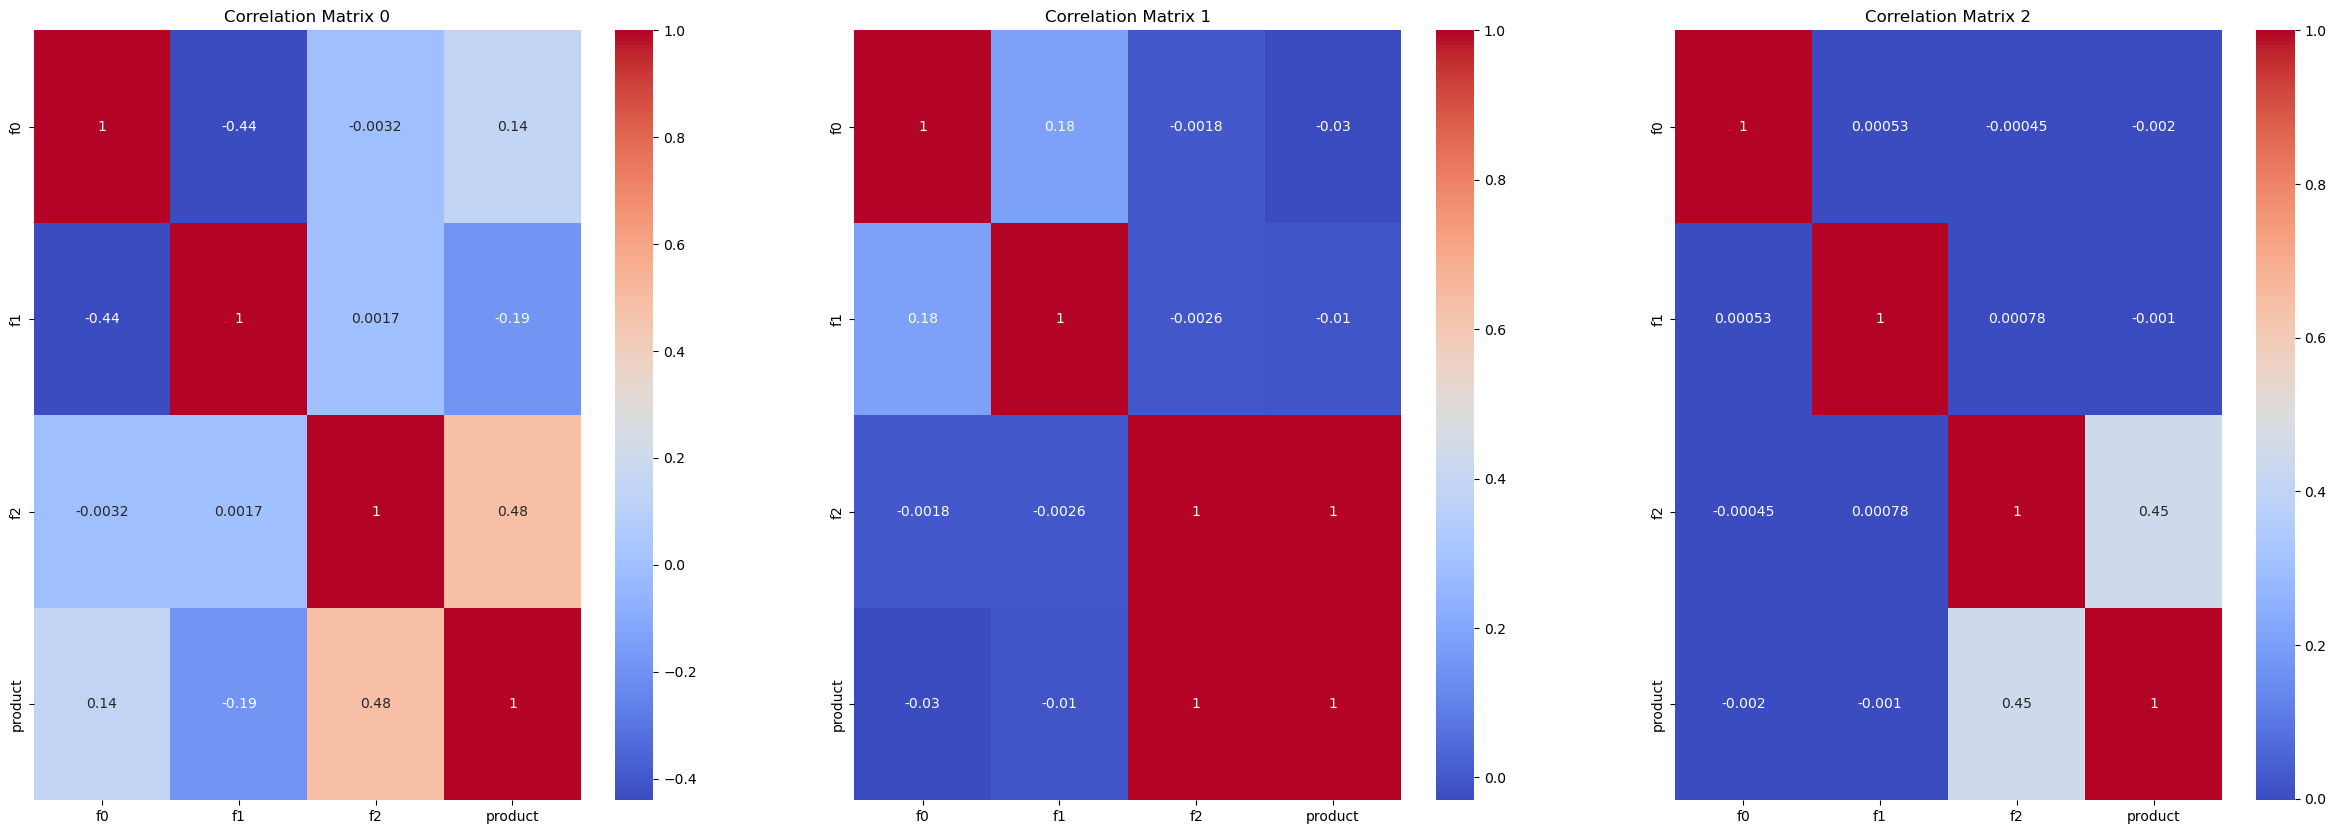

In [6]:
plt.figure(figsize=(30, 10))
for i, df in enumerate(data_frames):
    correlation_matrix = df.corr()
    plt.subplot(1, 3, i + 1)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix {i}')
plt.show()

<div class="alert alert-block alert-info">
<b>

Correlation Matrix 0
1.   Relaciones Fuertes: 
* Se observas que f0 y f1 tienen una correlación de  -0.44, por lo que hay una relación negativa entre estas dos variables.
* Se observas que f2 y producto tienen una correlación de 0.48, por lo que hay una relación positiva entre estas dos variables.
2.  Relaciones Débiles: 
* Todas las demás variables tienen una correlación débil

Correlation Matrix 1
1.   Relaciones Fuertes: 
* Se observas que f2 y producto tienen una correlación de 1, por lo que hay una relación positiva grande entre estas dos variables.
2.  Relaciones Débiles: 
* Todas las demás variables tienen una correlación débil

Correlation Matrix 2
1.   Relaciones Fuertes: 
* Se observas que f2 y producto tienen una correlación de 0.45, por lo que hay una relación positiva entre estas dos variables.
2.  Relaciones Débiles: 
* Todas las demás variables tienen una correlación débil

Conclusiones:

1. Estudial la correlación negativa entre f0 y f1 en el archivo 0 y por que no se mantiene en los otros archivos
2. Estudia la correlación positiva entre f2 y producto en los archivos 1 y por que disminuye en los archivos 0 y 2


</b> <a class="tocSkip"></a>


In [7]:
#sns.pairplot(data_2)

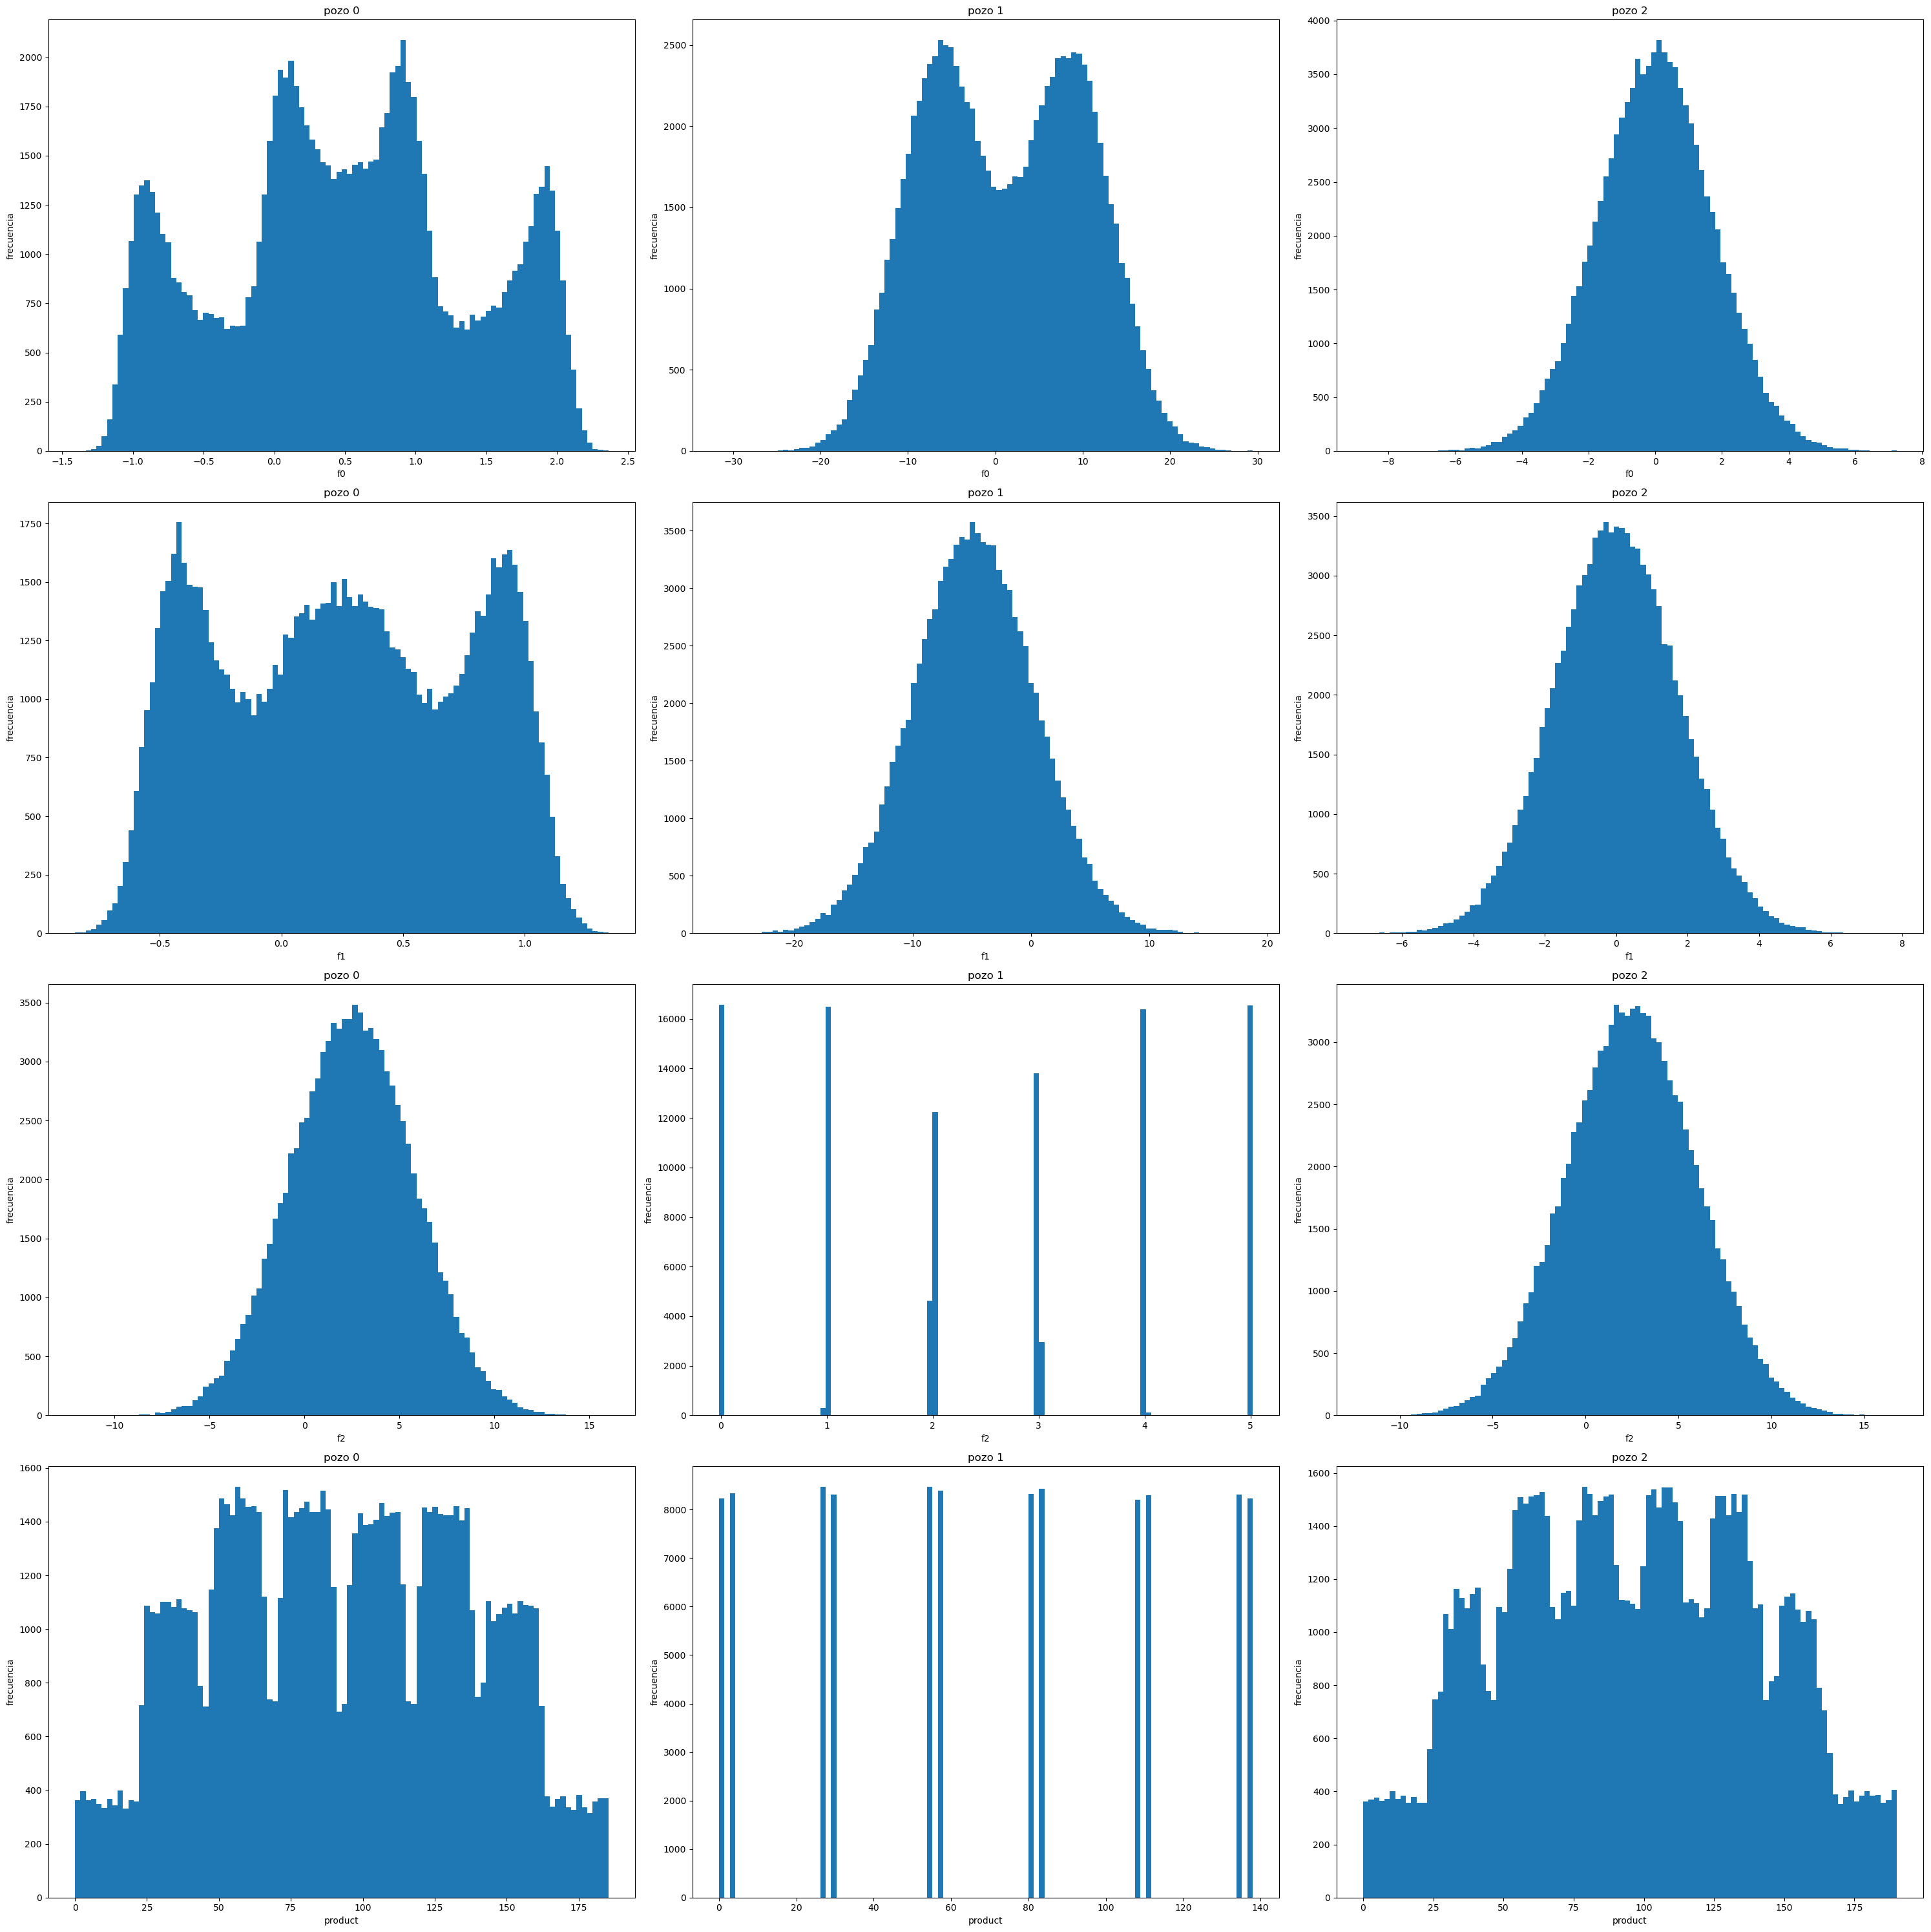

In [8]:
features = ['f0', 'f1', 'f2', 'product']
titles = ['pozo 0', 'pozo 1', 'pozo 2']

plt.figure(figsize=(30, 30))

# Loop through features and datasets
for i, feature in enumerate(features):
    for j, data in enumerate(data_frames):
        plt.subplot(4, 3, i * 3 + j + 1)
        data[feature].plot(kind='hist', bins=100)
        plt.xlabel(feature)
        plt.ylabel('frecuencia')
        plt.title(titles[j])

plt.tight_layout()
plt.show()

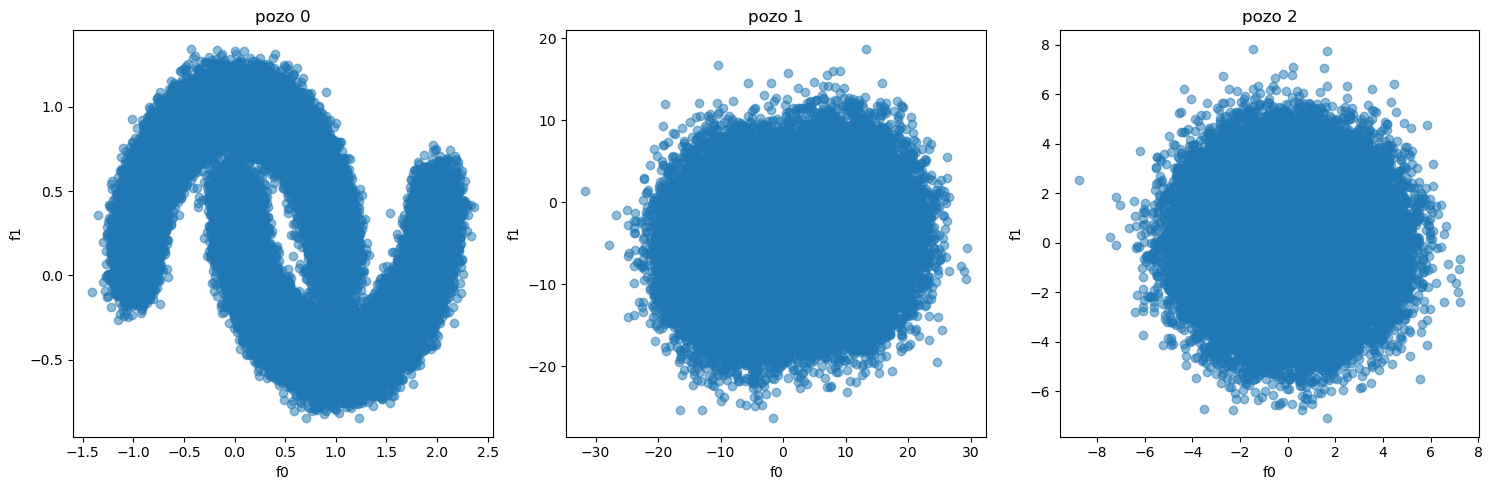

In [9]:
plt.figure(figsize=(15, 5))
for i, data in enumerate(data_frames):
    plt.subplot(1, 3, i + 1)
    plt.scatter(data['f0'], data['f1'], alpha=0.5)
    plt.xlabel('f0')
    plt.ylabel('f1')
    plt.title(titles[i])

plt.tight_layout()
plt.show()

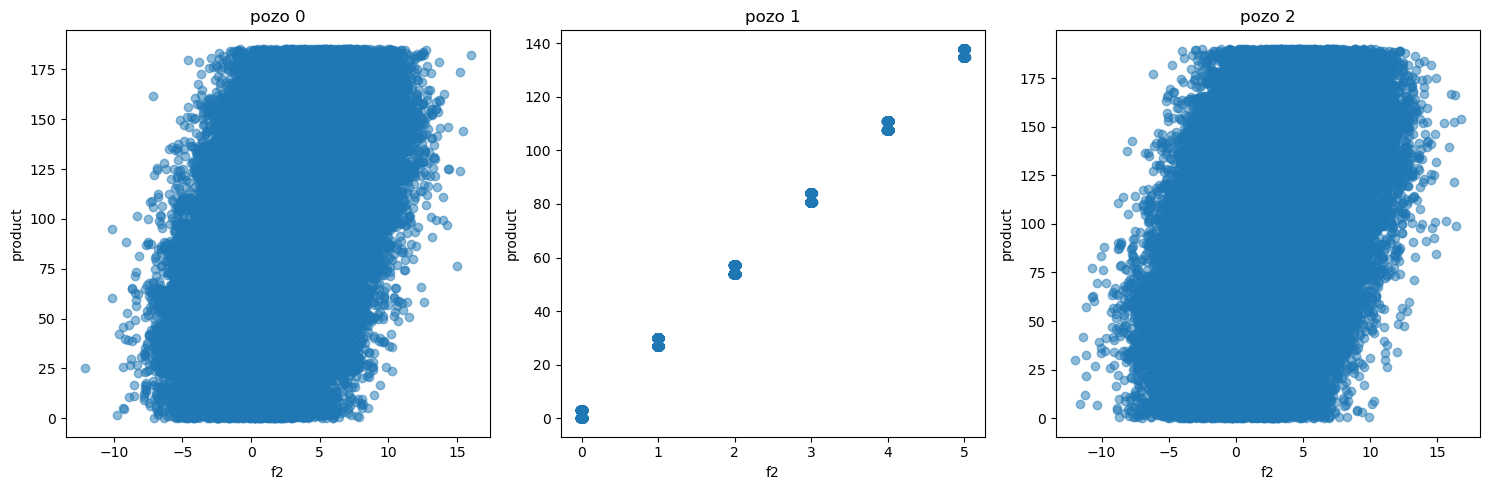

In [10]:
plt.figure(figsize=(15, 5))
for i, data in enumerate(data_frames):
    plt.subplot(1, 3, i + 1)
    plt.scatter(data['f2'], data['product'], alpha=0.5)
    plt.xlabel('f2')
    plt.ylabel('product')
    plt.title(titles[i])

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<b>

Conclusiones examinación de datos:

1. La correlación negativa entre f0 y f1 para data_0  se debe a la asimetria entre los picos (4 y 3 picos) que no esta presente en los datos_1 y datos_2
2. La correlación positiva entre f2 y producto para los datos_1 se debe a que son iguales, además de tener valores discretos. Se procederá a eliminar la columna f2 para los datos_1

Recomendaciones:

1. Realizar el análisis de regresión lineal para los datos_2 ya que todas las características siguen una distribución normal. Dependoiendo de los resultados decidir si se emplea el método de bootstraping.
2. Para los datos_0 se puede utilizar el método de bootstraping para obtener una distribución de f0 y f1.
3. Para los datos_1 se puede utilizar el método de bootstraping para obtener una distribución de f0 y realizar el análisis de regresión lineal solo para las características f0 y f1.

</b> <a class="tocSkip"></a>




## 2. Segmenta los datos en un conjunto de entrenamiento, uno de validación y uno de prueba y entrenar un modelo de rgresión lineal

In [11]:
def linear_regression_model(data):
    '''
    Esta función entrena un modelo de regresión lineal y calcula el error cuadrático medio.
    
    Parámetros:
        data: DataFrame con las características y la variable objetivo
    
    1. Separar las características (f0, f1, f2,) y la variable objetivo (product)
        target = data['product']
        features = data.drop(['product'], axis=1)
    2. Dividir los datos en conjuntos de entrenamiento (75%) y prueba (25%)
        X: características
        Y: variable objetivo
        X_train, y_train: Conjunto de entrenamiento
        X_test, y_test: Conjunto de prueba
    3. Entrenar el modelo de regresión lineal
        model = LinearRegression()
        model.fit(X_train, y_train)
    4. Obtener la predicción del modelo de regresión lineal ya entrenado
        y_pred = model.predict(X_test)
    5. Calcular el error cuadrático medio
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)**0.5
    6. Retornar la predicción del modelo entrenado y el error cuadrático medio
        return model, mse, rmse, r2, mae, y_test, y_pred
    '''
    target = data['product']
    features = data.drop(['product'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)**0.5
    return model, mse, rmse, r2, mae, y_test, y_pred

In [12]:
#help(linear_regression_model)

### 2.1 Modelo de regresión lineal: geo_data_2.csv

Model Coefficients: [-0.08415777 -0.01546094  5.75011968]
Model Intercept: 80.55786205197195
Mean Squared Error:  1611.6910636385905
Root Mean Squared Error:  40.14587231134218
Mean Absolute Error:  5.735587032778603
R2 Score:  0.19634705977280464


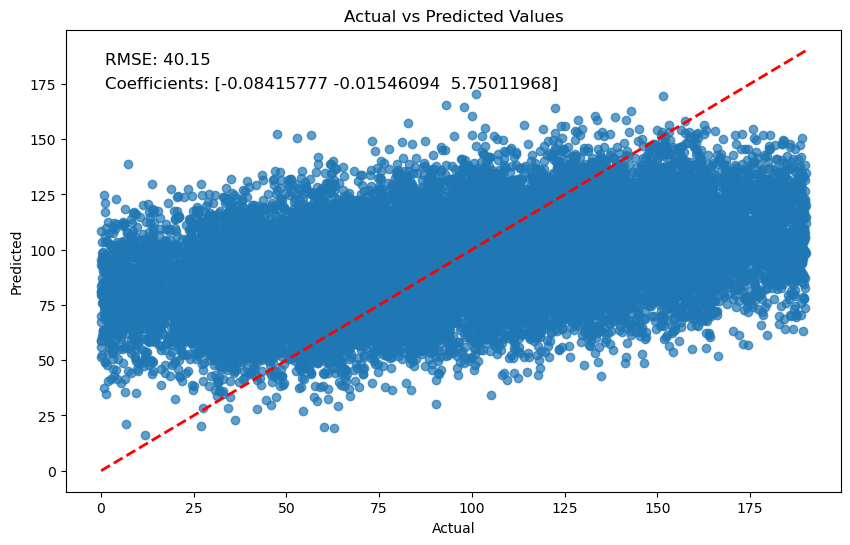

In [13]:
linear_regression_model(data_2)
model_2, mse_2, rmse_2, r2_2, mae_2, y_test_2, y_pred_2 = linear_regression_model(data_2)
print(f'Model Coefficients: {model_2.coef_}')
print(f'Model Intercept: {model_2.intercept_}')
print('Mean Squared Error: ', mse_2)
print('Root Mean Squared Error: ', rmse_2)
print('Mean Absolute Error: ', mae_2)
print('R2 Score: ', r2_2)


plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, y_pred_2, alpha=0.7)
plt.plot([y_test_2.min(), y_test_2.max()], [y_test_2.min(), y_test_2.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.text(0.05, 0.95, f'RMSE: {rmse_2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Coefficients: {model_2.coef_}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


<div class="alert alert-block alert-info">
<b>

* **Coeficientes del Modelo:** La tercera característica (f2) tiene el mayor impacto positivo en la variable objetivo, seguida por la primera característica (f0) y la segunda característica (f1).

* **Intercepto del Modelo:** El intercepto del modelo es 80.56. Este es el valor medio esperado de la variable objetivo cuando todas las características son cero.

* **Error Cuadrático Medio (MSE):** El MSE es 1611.6910636385905. Este métrica indica la diferencia cuadrática media entre los valores reales y los valores predichos. Un MSE más bajo indica un mejor ajuste.

* **Raíz del Error Cuadrático Medio (RMSE):** El RMSE sugiere que las predicciones del modelo están, en promedio, a 40.15 unidades de los valores reales.

* **Error Absoluto Medio (MAE):** El MAE sugiere que las predicciones del modelo están, en promedio, a 5.74 unidades de los valores reales.

* **Coeficiente de Determinación (R2):** Esta métrica indica la proporción de la varianza en la variable objetivo que es predecible a partir de las características. Un R2 de 0.196 sugiere que el modelo explica aproximadamente el 19.6% de la varianza en la variable objetivo, lo cual es relativamente bajo.

**Conclusión:**

El modelo de regresión lineal tiene un coeficiente de determinación (R2) relativamente bajo, lo que indica que no explica mucha de la varianza en la variable objetivo. Los valores de RMSE y MAE sugieren que las predicciones del modelo no son muy precisas. Esto implica que el modelo de regresión lineal puede no ser la mejor opción para este conjunto de datos, y otros modelos más complejos o una ingeniería de características adicional podrían ser necesarios para mejorar el rendimiento predictivo.

Se empleará el método de bootstraping para obtener una distribución de los beneficios y riesgos de la región.

</b> <a class="tocSkip"></a>

### 2.2 Modelo de regresión lineal: geo_data_1.csv

Model Coefficients: [-1.44912960e-01 -2.16715104e-02  2.69531092e+01]
Model Intercept: 1.6476710499672294
Mean Squared Error:  0.7925986566392013
Root Mean Squared Error:  0.890280100102884
Mean Absolute Error:  0.8467655835992954
R2 Score:  0.9996245232002449


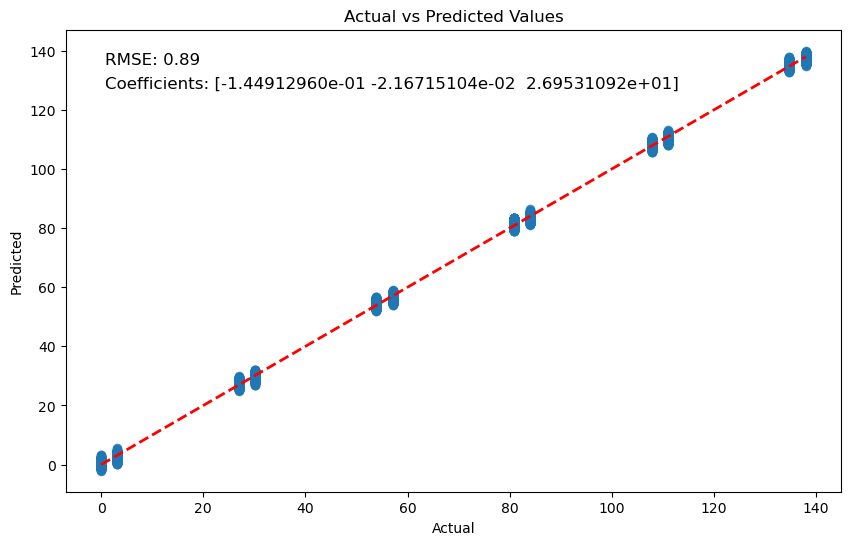

In [14]:
model_1, mse_1, rmse_1, r2_1, mae_1, y_test_1, y_pred_1 = linear_regression_model(data_1)
print(f'Model Coefficients: {model_1.coef_}')
print(f'Model Intercept: {model_1.intercept_}')
print('Mean Squared Error: ', mse_1)
print('Root Mean Squared Error: ', rmse_1)
print('Mean Absolute Error: ', mae_1)
print('R2 Score: ', r2_1)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_1, y_pred_1, alpha=0.7)
plt.plot([y_test_1.min(), y_test_1.max()], [y_test_1.min(), y_test_1.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.text(0.05, 0.95, f'RMSE: {rmse_1:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Coefficients: {model_1.coef_}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

<div class="alert alert-block alert-info">
<b>

Realizar el análisis de regresión lineal solo para las características f0 y f1 ya que f2 es igual a producto.

</b> <a class="tocSkip"></a>


Model Coefficients: [-0.15447391 -0.03419258]
Model Intercept: 68.86816314481217
Mean Squared Error:  2109.01375195071
Root Mean Squared Error:  45.92399973816207
Mean Absolute Error:  6.348164860932298
R2 Score:  0.0008994746725460301


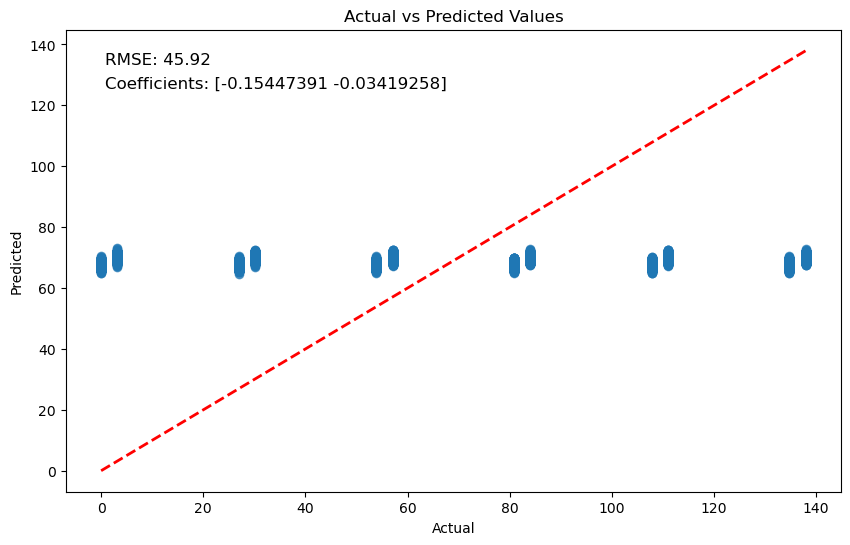

In [15]:
data_1_drop = data_1.drop('f2', axis=1)
model_drop_1, mse_drop_1, rmse_drop_1, r2_drop_1, mae_drop_1, y_test_drop_1, y_pred_drop_1 = linear_regression_model(data_1_drop)
print(f'Model Coefficients: {model_drop_1.coef_}')
print(f'Model Intercept: {model_drop_1.intercept_}')
print('Mean Squared Error: ', mse_drop_1)
print('Root Mean Squared Error: ', rmse_drop_1)
print('Mean Absolute Error: ', mae_drop_1)
print('R2 Score: ', r2_drop_1)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_drop_1, y_pred_drop_1, alpha=0.7)
plt.plot([y_test_drop_1.min(), y_test_drop_1.max()], [y_test_drop_1.min(), y_test_drop_1.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.text(0.05, 0.95, f'RMSE: {rmse_drop_1:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Coefficients: {model_drop_1.coef_}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


<div class="alert alert-block alert-info">
<b>

* **Coeficientes del Modelo:** La primera característica (f0) tiene el mayor impacto negativo en la variable objetivo

* **Intercepto del Modelo:** El intercepto del modelo es 68.87 Este es el valor medio esperado de la variable objetivo cuando todas las características son cero.

* **Error Cuadrático Medio (MSE):** El MSE es 2109.01375195071. Este métrica indica la diferencia cuadrática media entre los valores reales y los valores predichos. Un MSE más bajo indica un mejor ajuste.

* **Raíz del Error Cuadrático Medio (RMSE):** El RMSE sugiere que las predicciones del modelo están, en promedio, a 45.92 unidades de los valores reales.

* **Error Absoluto Medio (MAE):** El MAE sugiere que las predicciones del modelo están, en promedio, a 6.35 unidades de los valores reales.

* **Coeficiente de Determinación (R2):** Esta métrica indica la proporción de la varianza en la variable objetivo que es predecible a partir de las características.
El valor es muy cercano a 0, lo que sugiere que el modelo no está capturando bien la relación entre las variables independientes y la variable dependiente.

**Conclusión:**

El modelo de regresión lineal tiene un coeficiente de determinación (R2) muy cercano a cero, lo que indica que no explica la varianza en la variable objetivo. Los valores de RMSE y MAE sugieren que las predicciones del modelo no son muy precisas. Esto implica que el modelo de regresión lineal puede no ser la mejor opción para este conjunto de datos, y otros modelos más complejos o una ingeniería de características adicional podrían ser necesarios para mejorar el rendimiento predictivo.

Se empleará el método de bootstraping para obtener una distribución de los beneficios y riesgos de la región.

</b> <a class="tocSkip"></a>

### 2.3 Modelo de regresión lineal: geo_data_0.csv

Model Coefficients: [  3.83225372 -14.26047297   6.59357294]
Model Intercept: 77.66624978042196
Mean Squared Error:  1425.5608700093808
Root Mean Squared Error:  37.756600350261685
Mean Absolute Error:  5.572044646158911
R2 Score:  0.2728287328173472


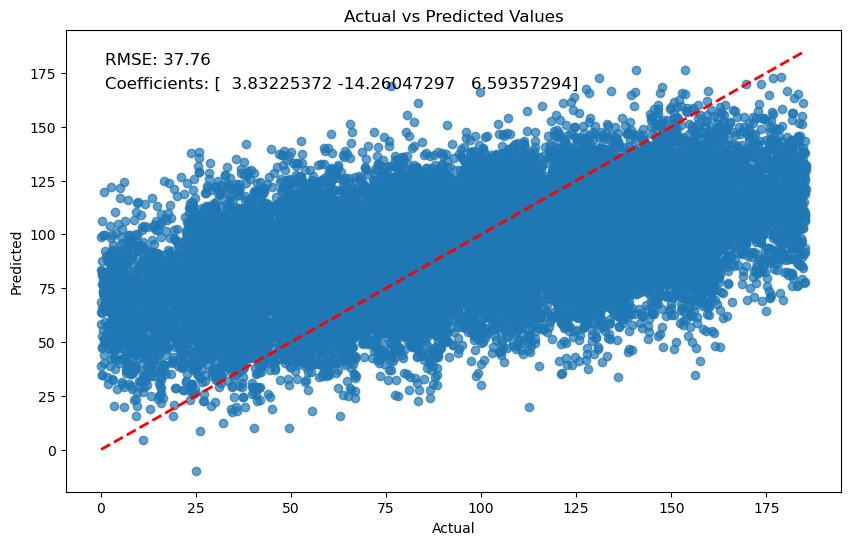

In [16]:
model_0, mse_0, rmse_0, r2_0, mae_0, y_test_0, y_pred_0 = linear_regression_model(data_0)
print(f'Model Coefficients: {model_0.coef_}')
print(f'Model Intercept: {model_0.intercept_}')
print('Mean Squared Error: ', mse_0)
print('Root Mean Squared Error: ', rmse_0)
print('Mean Absolute Error: ', mae_0)
print('R2 Score: ', r2_0)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_0, y_pred_0, alpha=0.7)
plt.plot([y_test_0.min(), y_test_0.max()], [y_test_0.min(), y_test_0.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.text(0.05, 0.95, f'RMSE: {rmse_0:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Coefficients: {model_0.coef_}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

<div class="alert alert-block alert-info">
<b>

* **Coeficientes del Modelo:** La tercera característica (f2) tiene el mayor impacto positivo en la variable objetivo, seguida por la segunda característica (negativa) (f1) y la primera característica (f0).

* **Intercepto del Modelo:** El intercepto del modelo es 77.66. Este es el valor medio esperado de la variable objetivo cuando todas las características son cero.

* **Error Cuadrático Medio (MSE):** El MSE es 1425.5608700093808. Este métrica indica la diferencia cuadrática media entre los valores reales y los valores predichos. Un MSE más bajo indica un mejor ajuste.

* **Raíz del Error Cuadrático Medio (RMSE):** El RMSE sugiere que las predicciones del modelo están, en promedio, a 37.75 unidades de los valores reales.

* **Error Absoluto Medio (MAE):** El MAE sugiere que las predicciones del modelo están, en promedio, a 5.72 unidades de los valores reales.

* **Coeficiente de Determinación (R2):** Esta métrica indica la proporción de la varianza en la variable objetivo que es predecible a partir de las características. Un R2 de 0.273 sugiere que el modelo explica aproximadamente el 27.3% de la varianza en la variable objetivo, lo cual es relativamente bajo, pero es el valor mas alto de los tres conjuntos de datos.

**Conclusión:**

El modelo de regresión lineal tiene un coeficiente de determinación (R2) relativamente bajo, lo que indica que no explica mucha de la varianza en la variable objetivo. Los valores de RMSE y MAE sugieren que las predicciones del modelo no son muy precisas. Esto implica que el modelo de regresión lineal puede no ser la mejor opción para este conjunto de datos, y otros modelos más complejos o una ingeniería de características adicional podrían ser necesarios para mejorar el rendimiento predictivo.

Se empleará el método de bootstraping para obtener una distribución de los beneficios y riesgos de la región.

</b> <a class="tocSkip"></a>

## 3. Ganancias y riesgos

In [17]:
def profit(target, predictions, inversion, pozos, precio_barril):
    '''
    Esta función calcula la ganancia de la empresa petrolera.
    
    Parámetros:
        target: variable objetivo
        predictions: predicciones
        inversion: inversión
        pozos: cantidad de pozos
        precio_barril: precio del barril de petróleo
    '''
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:pozos]
    profit = (selected.sum() * precio_barril) - inversion
    return profit

In [18]:
y_test_0 = pd.Series(y_test_0, index = y_test_0.index)
y_pred_0 = pd.Series(y_pred_0, index = y_test_0.index)
y_test_1 = pd.Series(y_test_1, index = y_test_1.index)
y_pred_1 = pd.Series(y_pred_1, index = y_test_1.index)

y_test_drop_1 = pd.Series(y_test_drop_1, index = y_test_drop_1.index)
y_pred_drop_1 = pd.Series(y_pred_drop_1, index = y_test_drop_1.index)

y_test_2 = pd.Series(y_test_2, index = y_test_2.index)
y_pred_2 = pd.Series(y_pred_2, index = y_test_2.index)

inversion = 100000000
pozos = 200
precio_barril = 4500
print ('Ganancia de 200 barriles, de la región 2: $',profit(y_test_0, y_pred_0, inversion, pozos, precio_barril),'USD')
print ('Ganancia de 200 barriles, de la región 1 $',profit(y_test_1, y_pred_1, inversion, pozos, precio_barril),'USD')
print ('Ganancia de 200 barriles, de la región 1 sin f2: $',profit(y_test_drop_1, y_pred_drop_1, inversion, pozos, precio_barril),'USD')
print ('Ganancia de 200 barriles, de la región 0: $',profit(y_test_2, y_pred_2, inversion, pozos, precio_barril),'USD')


Ganancia de 200 barriles, de la región 2: $ 33591411.14462179 USD
Ganancia de 200 barriles, de la región 1 $ 24150866.966815114 USD
Ganancia de 200 barriles, de la región 1 sin f2: $ -37949446.44985232 USD
Ganancia de 200 barriles, de la región 0: $ 25985717.59374112 USD


In [19]:
def bootstrap(y_test, y_pred):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        y_test_subsample = y_test.sample(500, replace=True, random_state = state)
        y_pred_subsample = y_pred[y_test_subsample.index]
        values.append(profit(y_test_subsample, y_pred_subsample, inversion, pozos, precio_barril))
    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)

    mean = values.mean()
    
    print('95% confidence interval:', lower, higher)
    print('95% confidence interval:', lower, higher)
    print("Average profit:", mean)
    print("2.5% quantile:", lower)
    print('Risk of loses:', (values < 0).mean())

In [20]:
print('geo_data_0')
bootstrap(y_test_0, y_pred_0)
print()
print('geo_data_1')
bootstrap(y_test_1, y_pred_1)
print()
print('geo_data_1 sin f2')
bootstrap(y_test_drop_1, y_pred_drop_1)
print()
print('geo_data_2')
bootstrap(y_test_2, y_pred_2)


geo_data_0
95% confidence interval: -1162316.127772087 9665041.807073751
95% confidence interval: -1162316.127772087 9665041.807073751
Average profit: 4359337.721386622
2.5% quantile: -1162316.127772087
Risk of loses: 0.061

geo_data_1
95% confidence interval: 551161.772736155 9057626.504248397
95% confidence interval: 551161.772736155 9057626.504248397
Average profit: 4896612.544117524
2.5% quantile: 551161.772736155
Risk of loses: 0.011

geo_data_1 sin f2
95% confidence interval: -43224085.600697204 -31456670.2166453
95% confidence interval: -43224085.600697204 -31456670.2166453
Average profit: -37209932.10759051
2.5% quantile: -43224085.600697204
Risk of loses: 1.0

geo_data_2
95% confidence interval: -1531169.8476190444 9528874.167078601
95% confidence interval: -1531169.8476190444 9528874.167078601
Average profit: 4036879.2786213835
2.5% quantile: -1531169.8476190444
Risk of loses: 0.071


<div class="alert alert-block alert-info">
<b>

* **Región geo_data_2.csv:** El promedio de ganancias es positivo, pero el riesgo de pérdidas es del 7.1%, lo que indica una inversión con un riesgo moderado.

* **Región geo_data_1.csv:** El promedio de ganancias es negativo y el riesgo de pérdidas es del 100%, lo que sugiere que esta inversión es extremadamente riesgosa y no recomendable.

Esto se debe a que hay muy poca información del pzo ya que se descarto la característica f2

* **Región geo_data_0.csv:** El promedio de ganancias es positivo, pero el riesgo de pérdidas es del 6.1%, lo que no es despreciable.

**Conclusión:**

* La región geo_data_0.csv es la mejor opción para el desarrollo de pozos petrolíferos, ya que se espera que genere beneficios con el menor riesgo de pérdidas.

* Las regiones geo_data_1.csv no cumplen con el umbral de beneficio mínimo por pozo, por lo que se espera que generen pérdidas. 

* La región geo_data_2.csv también es una buena opción, pero tiene un riesgo de pérdidas ligeramente mayor que la región geo_data_0.csv.

</b> <a class="tocSkip"></a>

